C:\Users\shrut\lstm-env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


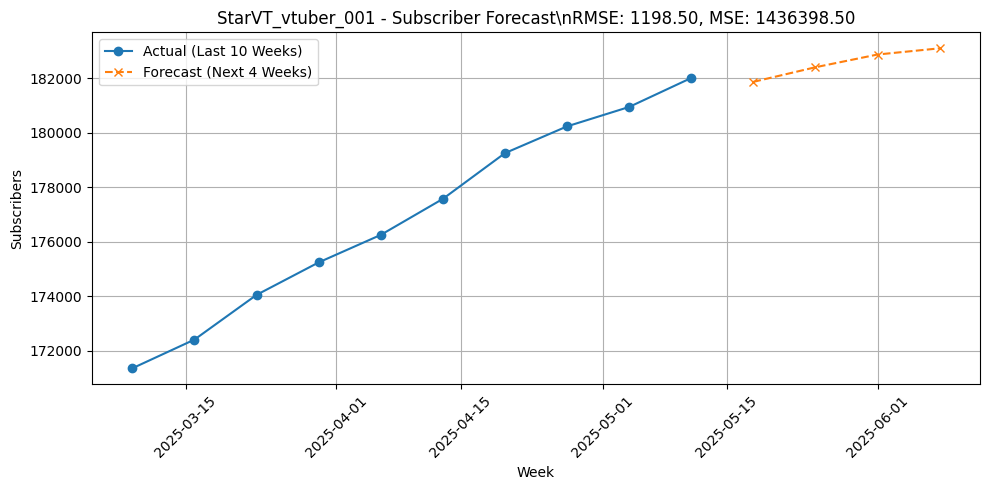

C:\Users\shrut\lstm-env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


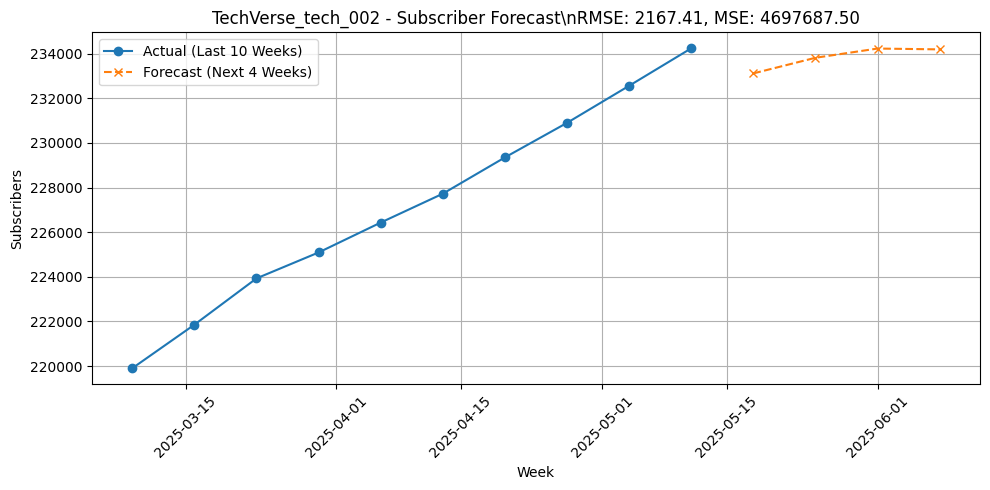

C:\Users\shrut\lstm-env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


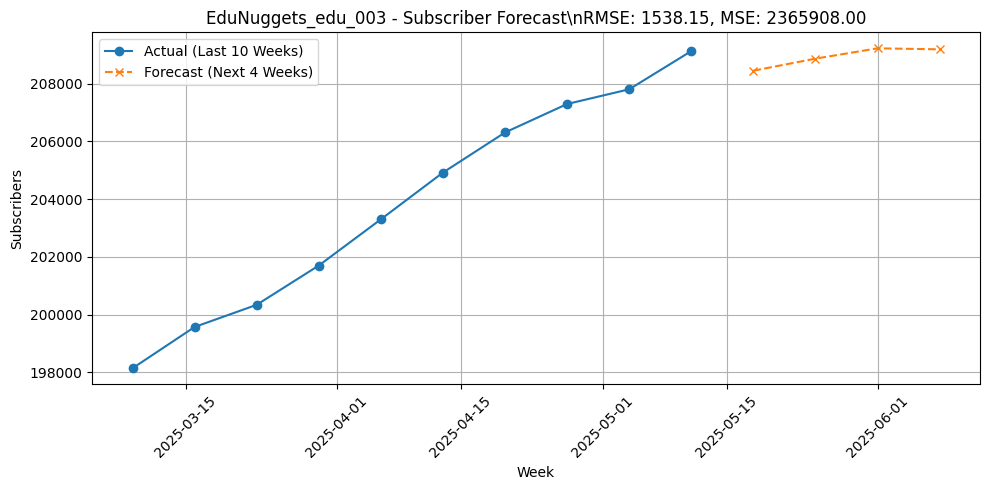

C:\Users\shrut\lstm-env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


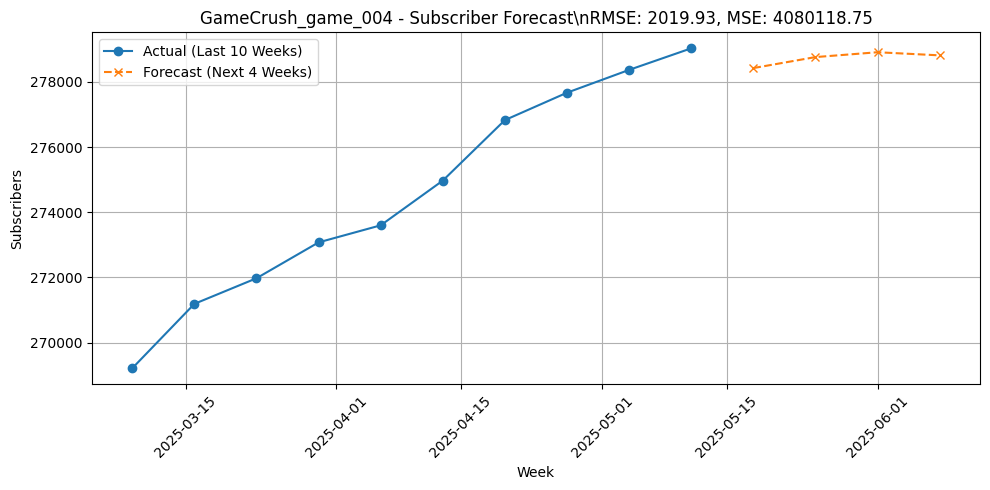

✅ Forecast saved to 'subscriber_forecast_lstm.csv'


In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from math import sqrt

# Load subscriber data
df = pd.read_csv("subscriber_data.csv")
df["date"] = pd.to_datetime(df["date"])

forecast_rows = []

for cid in df["channel_id"].unique():
    channel_df = df[df["channel_id"] == cid].sort_values("date").copy()
    values = channel_df["subscriber_count"].values.reshape(-1, 1)

    # Scale
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    # Create LSTM input/output sequences
    X, y = [], []
    for i in range(3, len(scaled)):
        X.append(scaled[i-3:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    # LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(3, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)

    # Forecast next 4 weeks
    input_seq = scaled[-3:].reshape(1, 3, 1)
    preds_scaled = []
    for _ in range(4):
        pred = model.predict(input_seq, verbose=0)
        preds_scaled.append(pred[0, 0])
        input_seq = np.concatenate([input_seq[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)

    # Inverse scale predictions
    preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()

    # Evaluate on last 4 weeks
    y_true = values[-4:].flatten()
    y_pred = scaler.inverse_transform(model.predict(X[-4:], verbose=0)).flatten()
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)

    # Prepare CSV rows (4 actual + 4 predicted)
    for i in range(-4, 0):
        forecast_rows.append({
            "channel_id": cid,
            "week_start": channel_df.iloc[i]["date"].strftime("%Y-%m-%d"),
            "type": "Actual",
            "subscriber_count": int(channel_df.iloc[i]["subscriber_count"]),
            "mse": round(mse, 2),
            "rmse": round(rmse, 2)
        })

    max_date = channel_df["date"].max()
    for i in range(4):
        forecast_rows.append({
            "channel_id": cid,
            "week_start": (max_date + timedelta(weeks=i+1)).strftime("%Y-%m-%d"),
            "type": "Predicted",
            "subscriber_count": int(preds[i]),
            "mse": round(mse, 2),
            "rmse": round(rmse, 2)
        })

    # Plot actual vs predicted
    actual = channel_df.tail(10)
    future_dates = [max_date + timedelta(weeks=i+1) for i in range(4)]

    plt.figure(figsize=(10, 5))
    plt.plot(actual["date"], actual["subscriber_count"], marker='o', label="Actual (Last 10 Weeks)")
    plt.plot(future_dates, preds, marker='x', linestyle='--', label="Forecast (Next 4 Weeks)")
    plt.title(f"{cid} - Subscriber Forecast\\nRMSE: {rmse:.2f}, MSE: {mse:.2f}")
    plt.xlabel("Week")
    plt.ylabel("Subscribers")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Save forecast to CSV
forecast_df = pd.DataFrame(forecast_rows)
forecast_df.to_csv("subscriber_forecast_lstm.csv", index=False)
print("✅ Forecast saved to 'subscriber_forecast_lstm.csv'")


In [1]:
!pip install nltk

In [5]:
import nltk
nltk.download("stopwords")
nltk.download("punkt")


ModuleNotFoundError: No module named 'nltk'

In [6]:
import pandas as pd
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk

# Download NLTK resources (run once)
nltk.download('stopwords')
nltk.download('punkt')

# Load your comments data
df = pd.read_csv("comments_data_updated.csv")

stop_words = set(stopwords.words("english"))

# Preprocess comment text
def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    return [w for w in tokens if w.isalpha() and w not in stop_words]

df["tokens"] = df["comment_text"].apply(preprocess)

# Count most common words by sentiment
positive_words = df[df["sentiment"] == "positive"]["tokens"].explode()
negative_words = df[df["sentiment"] == "negative"]["tokens"].explode()

pos_freq = Counter(positive_words)
neg_freq = Counter(negative_words)

# Create final DataFrame
word_data = []

for word, count in pos_freq.most_common(100):
    word_data.append({"word": word, "frequency": count, "sentiment": "positive"})

for word, count in neg_freq.most_common(100):
    word_data.append({"word": word, "frequency": count, "sentiment": "negative"})

word_df = pd.DataFrame(word_data)
word_df.to_csv("sentiment_wordcloud.csv", index=False)
print("✅ Saved as sentiment_wordcloud.csv")

ModuleNotFoundError: No module named 'nltk'